In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk 
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

from sklearn import model_selection, metrics, preprocessing, ensemble, model_selection, metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout, Input, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\poeun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\poeun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [31]:
# mlflow library
import mlflow
import argparse
import sys
from mlflow import pyfunc
import shutil
import tempfile
import tensorflow as tf
from tensorflow import estimator as tf_estimator
import mlflow.tensorflow

In [32]:
# Enable auto-logging to MLflow to capture TensorBoard metrics.
mlflow.tensorflow.autolog()

parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", default=100, type=int, help="batch size")
parser.add_argument("--train_steps", default=1000, type=int, help="number of training steps")

_StoreAction(option_strings=['--train_steps'], dest='train_steps', nargs=None, const=None, default=1000, type=<class 'int'>, choices=None, help='number of training steps', metavar=None)

## Read train data

In [33]:
# Rreading train dataset
file_path = "./data/train.csv"
raw_data = pd.read_csv(file_path)
print("Data points count: ", raw_data['id'].count())
raw_data.head()


Data points count:  7613


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


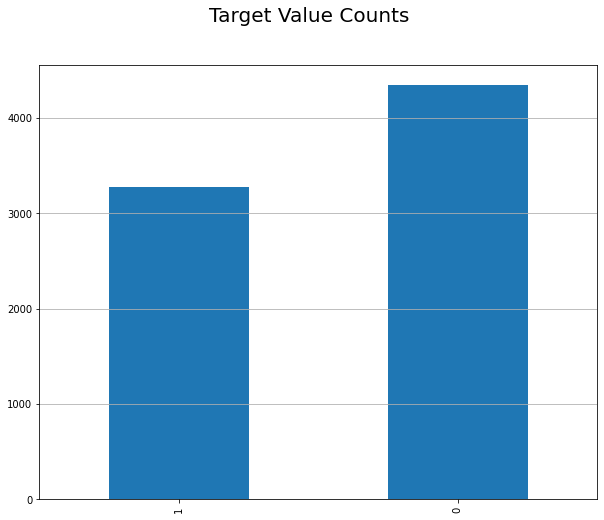

In [34]:
# Plotting target value counts
plt.figure(figsize=(10,8))
ax = raw_data['target'].value_counts().sort_values().plot(kind="bar")
ax.grid(axis="y")
plt.suptitle("Target Value Counts", fontsize=20)
plt.show()


## Missing Data

In [35]:
print("Number of missing data for column keyword: ", raw_data['keyword'].isna().sum())
print("Number of missing data for column location: ", raw_data['location'].isna().sum())
print("Number of missing data for column text: ", raw_data['text'].isna().sum())
print("Number of missing data for column target: ", raw_data['target'].isna().sum())


Number of missing data for column keyword:  61
Number of missing data for column location:  2533
Number of missing data for column text:  0
Number of missing data for column target:  0


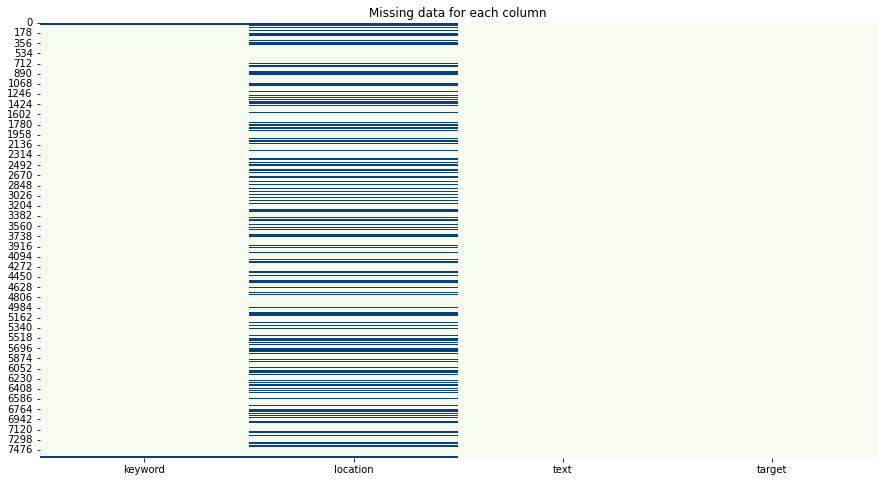

In [36]:
plt.figure(figsize=(15,8))
sns.heatmap(raw_data.drop('id', axis=1).isnull(), cbar=False, cmap="GnBu").set_title("Missing data for each column")
plt.show()

## Cleaning Data

C:\Users\poeun\anaconda3\envs\tf2.8\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


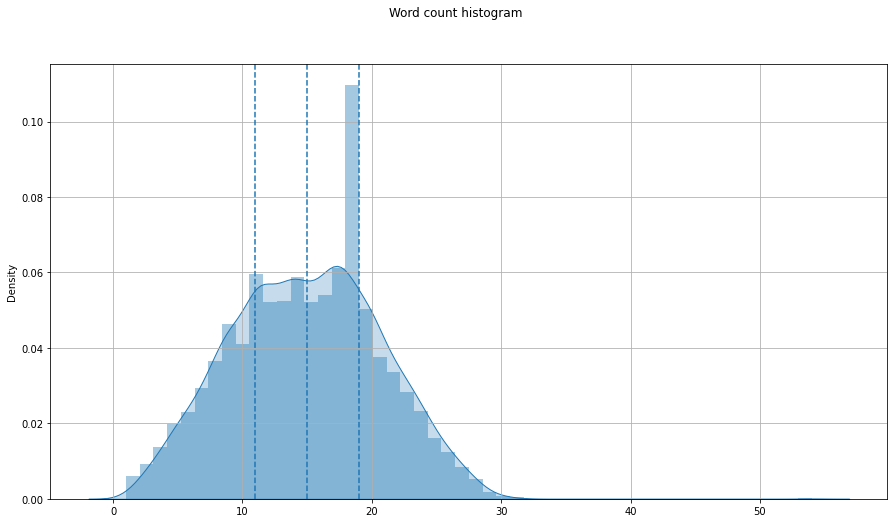

In [37]:
plt.figure(figsize=(15,8))
raw_data['word_count'] = raw_data['text'].apply(lambda x: len(x.split(" ")) )
sns.distplot(raw_data['word_count'].values, hist=True, kde=True, kde_kws={"shade": True})
plt.axvline(raw_data['word_count'].describe()['25%'], ls="--")
plt.axvline(raw_data['word_count'].describe()['50%'], ls="--")
plt.axvline(raw_data['word_count'].describe()['75%'], ls="--")

plt.grid()
plt.suptitle("Word count histogram")
plt.show()

# remove rows with under 3 words
raw_data = raw_data[raw_data['word_count']>2]
raw_data = raw_data.reset_index()


In [38]:
print("25th percentile: ", raw_data['word_count'].describe()['25%'])
print("mean: ", raw_data['word_count'].describe()['50%'])
print("75th percentile: ", raw_data['word_count'].describe()['75%'])

25th percentile:  11.0
mean:  15.0
75th percentile:  19.0


In [39]:
# Clean text columns
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')


def clean_text(each_text):

    # remove URL from text
    each_text_no_url = re.sub(r"http\S+", "", each_text)
    
    # remove numbers from text
    text_no_num = re.sub(r'\d+', '', each_text_no_url)

    # tokenize each text
    word_tokens = word_tokenize(text_no_num)
    
    # remove sptial character
    clean_text = []
    for word in word_tokens:
        clean_text.append("".join([e for e in word if e.isalnum()]))

    # remove stop words and lower
    text_with_no_stop_word = [w.lower() for w in clean_text if not w in stop_words]  

    # do stemming
    stemmed_text = [stemmer.stem(w) for w in text_with_no_stop_word]
    
    return " ".join(" ".join(stemmed_text).split())


raw_data['clean_text'] = raw_data['text'].apply(lambda x: clean_text(x) )
raw_data['keyword'] = raw_data['keyword'].fillna("none")
raw_data['clean_keyword'] = raw_data['keyword'].apply(lambda x: clean_text(x) )


In [40]:
# Combine column 'clean_keyword' and 'clean_text' into one
raw_data['keyword_text'] = raw_data['clean_keyword'] + " " + raw_data["clean_text"]


## Prepare train and test data

In [41]:
feature = 'keyword_text'
label = "target"

# split train and test
X_train, X_test,y_train, y_test = model_selection.train_test_split(raw_data[feature],
                                                                   raw_data[label],
                                                                   test_size=0.3,
                                                                   random_state=0, 
                                                                   shuffle=True)


# LSTM

In [42]:
# Define some hyperparameters
path_to_glove_file = 'F:/data/glove.6B.300d.txt' # download link: http://nlp.stanford.edu/data/glove.6B.zip
embedding_dim = 300
learning_rate = 1e-3
batch_size = 1024 # original : 1024
epochs = 10 # original : 20
sequence_len = 100


In [43]:
# Define train and test labels
y_train_LSTM = y_train.values.reshape(-1,1)
y_test_LSTM = y_test.values.reshape(-1,1)

print("Training Y shape:", y_train_LSTM.shape)
print("Testing Y shape:", y_test_LSTM.shape)


Training Y shape: (5294, 1)
Testing Y shape: (2270, 1)


In [44]:
# Tokenize train data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocabulary Size: ", vocab_size)


Vocabulary Size:  11148


In [45]:
# Pad train and test 
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=sequence_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=sequence_len)

print("Training X shape: ", X_train.shape)
print("Testing X shape: ", X_test.shape)


Training X shape:  (5294, 100)
Testing X shape:  (2270, 100)


In [46]:
# Read word embeddings
embeddings_index = {}
with open(path_to_glove_file, encoding='UTF8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


Found 400000 word vectors.


In [47]:
# Define embedding layer in Keras
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            weights=[embedding_matrix],
                                            input_length=sequence_len,
                                            trainable=False)


In [48]:
# Define model architecture
sequence_input = Input(shape=(sequence_len, ), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='relu')(embedding_sequences)
x = Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(sequence_input, outputs)
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 300)          3344400   
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           192128    
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                           

In [49]:
# Optimize the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])


In [50]:
# Train the LSTM Model
history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_data=(X_test, y_test))


Epoch 1/10
6/6 [==============================] - 35s 5s/step - loss: 0.6605 - accuracy: 0.5848 - val_loss: 0.5714 - val_accuracy: 0.7141
Epoch 2/10
6/6 [==============================] - 30s 5s/step - loss: 0.5491 - accuracy: 0.7440 - val_loss: 0.5155 - val_accuracy: 0.7599
Epoch 3/10
6/6 [==============================] - 30s 5s/step - loss: 0.4970 - accuracy: 0.7688 - val_loss: 0.5145 - val_accuracy: 0.7502
Epoch 4/10
6/6 [==============================] - 28s 5s/step - loss: 0.4788 - accuracy: 0.7760 - val_loss: 0.4896 - val_accuracy: 0.7744
Epoch 5/10
6/6 [==============================] - 29s 5s/step - loss: 0.4469 - accuracy: 0.7996 - val_loss: 0.4715 - val_accuracy: 0.7828
Epoch 6/10
6/6 [==============================] - 30s 5s/step - loss: 0.4254 - accuracy: 0.8109 - val_loss: 0.4872 - val_accuracy: 0.7824
Epoch 7/10
6/6 [==============================] - 30s 5s/step - loss: 0.4091 - accuracy: 0.8196 - val_loss: 0.4902 - val_accuracy: 0.7824
Epoch 8/10
6/6 [==================

INFO:tensorflow:Assets written to: C:\Users\poeun\AppData\Local\Temp\tmpj8dutw2r\model\data\model\assets
2022/04/07 12:15:01 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\poeun\AppData\Local\Temp\tmpj8dutw2r\model, flavor: keras), fall back to return ['tensorflow==2.8.0', 'keras==2.8.0']. Set logging level to DEBUG to see the full traceback.


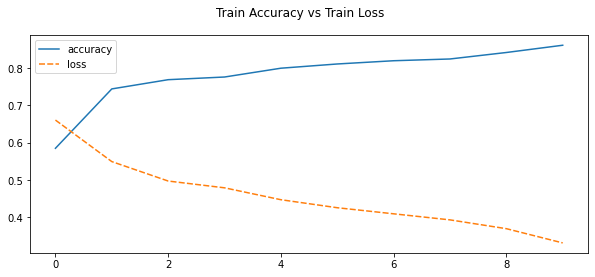

In [51]:
# Plot train accuracy and loss
accuraties = history.history['accuracy']
losses = history.history['loss']
accuraties_losses = list(zip(accuraties,losses))

accuraties_losses_df = pd.DataFrame(accuraties_losses, columns={"accuracy", "loss"})

plt.figure(figsize=(10,4))
plt.suptitle("Train Accuracy vs Train Loss")
sns.lineplot(data=accuraties_losses_df)
plt.show()


In [52]:
# Evaluate the model
predicted = model.predict(X_test, verbose=1, batch_size=10000)

y_predicted = [1 if each > 0.5 else 0 for each in predicted]

score, test_accuracy = model.evaluate(X_test, y_test, batch_size=10000)
mlflow.log_metric("SCORE", score)
mlflow.log_metric("TEST_ACCURACY", test_accuracy)

# mlflow.tensorflow.log_model(model, "model")


print("Test Accuracy: ", test_accuracy)
print(metrics.classification_report(list(y_test), y_predicted))


1/1 [==============================] - 0s 277ms/step - loss: 0.5027 - accuracy: 0.7890
Test Accuracy:  0.7889868021011353
              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1309
           1       0.85      0.61      0.71       961

    accuracy                           0.79      2270
   macro avg       0.80      0.77      0.77      2270
weighted avg       0.80      0.79      0.78      2270



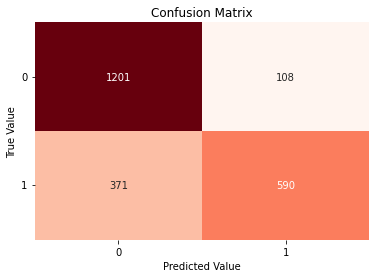

In [53]:
# Plot confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_predicted)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)
plt.show()
